# Moving from 1D to 3D Calculations

The biggest difference here is that now we are going to be working with GCM input. Currently, all this functionality is based on the output from the MIT GCM. I have worked with a few GCM groups to write tailored functions. If you are interested, contact a `picaso` code maintainer and we will work with your team. 

In any case, in what follows is a description of the input format so that you may replicate the functionality. 


In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import astropy.units as u

#picaso
from picaso import justdoit as jdi 
from picaso import justplotit as jpi
from picaso import build_3d_input as threed
#plotting
from bokeh.io import output_notebook
from bokeh.layouts import row
output_notebook()
from bokeh.plotting import show

import pickle as pk

Loading BokehJS ...

## Same procedure as normal

In [2]:
opacity = jdi.opannection(wave_range=[1.1,1.7])

start_case = jdi.inputs()

#phase angle 
num_gangle = 10
num_tangle = 10
phase = 0
start_case.phase_angle(phase,num_gangle=num_gangle, num_tangle=num_tangle) #radians

#define gravity
start_case.gravity(radius=1,radius_unit=u.Unit('R_jup'), mass=1, mass_unit=u.Unit('M_jup')) #any astropy units available

#define star 
start_case.star(opacity,5000,0,4.0, radius=1, radius_unit=u.Unit('R_sun')) #pysynphot database, temp, metallicity, logg 


## Build 3D Chemistry and PT Input

The biggest complication with moving to 3D is making sure that the latitude/longitude grids of some users GCM and `picaso` line up properly. `picaso` computes a flux integration on specific `gauss` and `chebychev` angles. Meaning, your GCM input will need to be regridded to fit our angles. Our prebuilt function, `picaso.build_3d_input.rebin_mitgcm_pt`, uses `scipy.spatial.cKDTree` to do rebinning. If you want to hack our methodology [this is the function you are after](https://github.com/natashabatalha/picaso/blob/master/picaso/build_3d_input.py). 

## 1) MIT GCM

The MIT GCM file is formated as such: 

    longitude1 latitude1
    p1 t1 kzz1
    p2 t2 kzz2
    ..
    longitude1 latitude2
    p1 t1 kzz1
    p2 t2 kzz2
    ..
    longitude1 latitudeN
    p1 t1 kzz1
    p2 t2 kzz2
    ..
    longitudeM latitudeN
    

If your file is structured like this then you can use `picaso.build_3d_input.rebin_mitgcm_pt` directly. If not, below I will teach you how to build the input from scratch. 

In [3]:
#define output file
outfile = 'HAT1.pk'


threed.rebin_mitgcm_pt(num_gangle,num_tangle,#here we define the num_gangles, and num_tangles
                       phase,                #and phase exactly as above. 
                       jdi.HJ_pt_3d(), #insert your input file here 
                       outfile, #define your output file 
                       p_unit='bar', #specify your pressure units 
                       run_chem=True, #tell picaso if you want to add post processed chemistry
                       MH=1,CtoO=0.55) #If so, specify metallicity and c/o (see further note below)

start_case.atmosphere_3d(filename=outfile)#add file to atmosphere. `atmosphere_3d` only works with dictionaries 
#that are in the proper format OR a `pickle` file of the dictionary.

**Note about run_chem. The _correct_ thing to do is to grab the full atmospheric chemical composition from the GCM output. If for whatever reason that is not available, you can set `run_chem` to True and it will compute the chemical equilibrium calculation for you.**

## 2) Building Generic Input

Below is an aside that shows the generic methodology of how you would build your 3D input file. 

### 1) Get required latitude/longitudes 

Convert latitudes and longitudes to degress and turn into integer values. 

In [4]:
lats = (start_case.inputs['disco']['latitude']*180/np.pi).astype(int)
lons = (start_case.inputs['disco']['longitude']*180/np.pi).astype(int)

### 2) Build dictionary to be used by 3D `picaso` 

In [5]:
dict_3d = {la: {lo : [] for lo in lons} for la in lats} #build empty one 
dict_3d['phase_angle'] = 0 #I required that phase angle be put in the dictionary. This because 
#all too often people take a 3d file they've binned for one phase angle, and use it on another phase angle. 

### 3) Fill dictionary with regridded GCM output

We use dictionaries as opposed to matrices so that there is never any confusion with what PT-composition data bundle is paired with what latitude longitude point. This also allows you to go back to your output file and check what points were run, what phase angle was used. 

In [6]:
for ilat in lats: 
    for ilon in lons:
        #EXAMPLE ONLY!!!! 
        dict_3d[ilat][ilon] = pd.DataFrame({'pressure':np.logspace(-5,2,52), 
                                                  'temperature':np.logspace(-5,2,52)*0+1000,#filler values
                                                  'H2O':np.logspace(-5,2,52)*0+0.1,#your GCM
                                                  'H2' : np.logspace(-5,2,52)*0+0.70, #input will go 
                                                  'He':np.logspace(-5,2,52)*0+0.29}) #here

#this is just an example. But, once you fill out this dict with yoru 3D input you can directly put it into 
#picaso: 
#start_case.atmosphere_3d(dictionary=dict_3d)

## Create 1D Thermal Emission Spectrum from 3D Output

Let's create our first spectrum of HAT 1's thermal emission 

In [7]:
#only difference is we need to speciy 3d 
out = start_case.spectrum(opacity,dimension='3d',calculation='thermal',full_output=True)


**NOTE** You can just as well use `calculation='reflected'`. I just chose this as an example.  

In [14]:
#same old same old
wno,fpfs = jdi.mean_regrid(out['wavenumber'],out['fpfs_thermal'],R=100)
show(jpi.spectrum(wno, fpfs*1e6, plot_width=500,y_axis_type='log'))

## Analyze 3D Output

Some of the functionality you will recognize from other tutorials (e.g. the thermal emission tutorial). The only difference is that you will need to add `ng` and `nt` to specify which facet you want to look at. 

## Compare flux to blackbodies 

This is the same plot as was in the 1D Thermal Emission tutorial. However, we again have to specify the `ng` and `nt` angles that we are looking at. 

In [9]:
show(jpi.flux_at_top(out ,
                     pressures = [10,1,1e-1],
                     ng=0,nt=0,R=100,
                     plot_height=500, plot_width=500))#note the addition of ng and nt

## 3D Map of Flux 

We can use the same plot as we used for reflected light. In 3D this plot is quite a bit more interesting since we can see variations accross the disk from out input file. 

**Note** below I specify `thermal`. The default is `reflected`, I just chose this as an example.

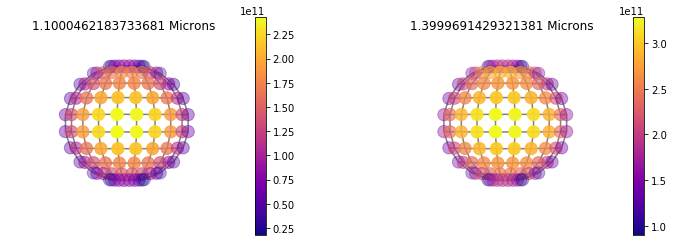

In [10]:
jpi.disco(out['full_output'] ,wavelength=[1.1, 1.4], calculation='thermal')

## More 3D Mapping Functions

In addition to `disco` there is now a general `map` function that can plot anything in `picaso`'s full output `dict`. Below is an example of the `taugas` where we must specify both a `pressure` and `wavelenth` to plot the map

### Example of Molecular Opacity Map 

When runnint `map` for a 4D (nlevel,nlayer, nwave, nlong, nlat) you can speficy  

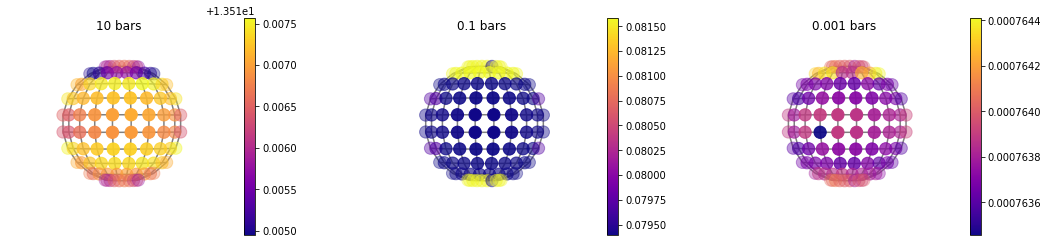

In [11]:
#Since Taugas is [nlayer, nwave, nlong, nlat] we can specify a list of pressures and a SINGLE wavelength.
jpi.map(out['full_output'],plot='taugas',pressure=[10,0.1,1e-3],wavelength=0.5)

### Example of Temperature Map

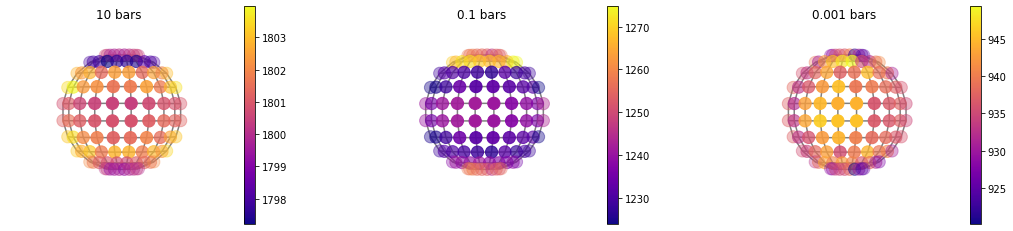

In [12]:
#Since temperature is [nlayer, nlong, nlat] we just have to specify a list of pressures 

jpi.map(out['full_output'],plot='temperature',pressure=[10,0.1,1e-3])

### Example of Tau~1 Pressure Map

Here we can break down a full map of the molecular, cloud and rayleigh opacity. Whereas in `map` we had to specify a specific pressure and wavelength, here we can specify an opactical depth and it will produce a map of what pressure level corresponds to that optical depth. We tend to see photons that originate from tau=1. Therefore, it is interesting to plot a tau=1 map so we can see if we are seeing different pressure levels at different locations accross the disk. 

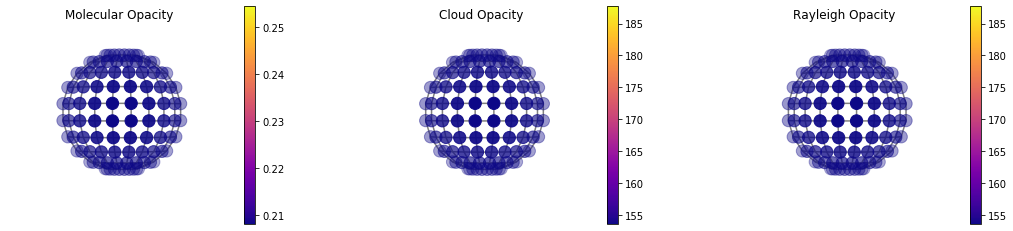

In [13]:
#This is not a terribly interesting case since the lat/lon variation in abundance is relatively small 
#and we never gave it a specific cloud opacity...
#BUT, the functionality exists for cases that are more interest :) 
jpi.taumap(out['full_output'], wavelength=1.4, at_tau=1)